In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter,white_signals,gp_signals,signal_base
from enterprise.signals.utils import powerlaw

from enterprise_extensions import blocks
from enterprise_extensions.model_utils import get_tspan

from la_forge.core import Core

import sys
sys.path.append('../')
sys.path.append('../../PerFreqOS')

from OSplusplus import OSplusplus as ospp
from OSplusplus import utils

from PFOS.optimal_statistic import OptimalStatistic
from PFOS.pfos_functions import compute_normPFOS
from PFOS.psr_pair_covariance import pair_covariant_OS

In [2]:
datadir = enterprise.__path__[0] + '/datafiles/mdc_open1/'
parfiles = sorted(glob(datadir + '/*.par'))
timfiles = sorted(glob(datadir + '/*.tim'))

psrs = [Pulsar(par,tim) for par,tim in zip(parfiles,timfiles)]

inj_params = {'gw_log10_A':np.log10(5e-14),'gw_gamma':(13./3.)}

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [3]:
Tspan = get_tspan(psrs)

efac = parameter.Constant(1.0)
ef = white_signals.MeasurementNoise(efac=efac)

curn = blocks.common_red_noise_block(psd='powerlaw',Tspan=Tspan,components=10,
                                     gamma_val=13./3.,logmin=-18,logmax=-12,name='gw')

tm = gp_signals.TimingModel(use_svd=True)

model = tm + ef + curn

pta = signal_base.PTA([model(psr) for psr in psrs])

lfcore_loc = 'MDC1_FG_CURN_samples.core'
lfcore = Core(corepath=lfcore_loc)

Loading data from HDF5 file....


In [4]:
old_os = OptimalStatistic(psrs,pta=pta)

t_xi, t_rho, t_sig, t_A2, t_A2s = old_os.compute_os(inj_params)
print(np.sqrt(t_A2),t_A2s)

t_xi, t_rho, t_Sigma, t_A2, t_A2s = pair_covariant_OS(old_os,inj_params)
print(np.sqrt(t_A2),t_A2s)

5.010145033907425e-14 1.9089582040924484e-28


Pairs of pairs: 100%|███████████████| 198765/198765 [00:00<00:00, 581872.98it/s]


5.02815569780616e-14 5.195923442574318e-28


In [5]:
t1 = ospp(psrs,pta,core=lfcore)

xi,rho,sig,C,a2,a2s = t1.compute_os(params=inj_params, pair_covariance=False, save_pair_vals=True)
print(np.sqrt(a2),a2s)

xi,rho,sig,C,a2,a2s = t1.compute_os(params=inj_params, pair_covariance=True, save_pair_vals=True)
print(np.sqrt(a2),a2s)

5.010145033906853e-14 1.9089582040924486e-28


Pairs of pairs: 100%|███████████████| 198765/198765 [00:00<00:00, 570791.82it/s]


5.0281556978050304e-14 5.195923442574315e-28


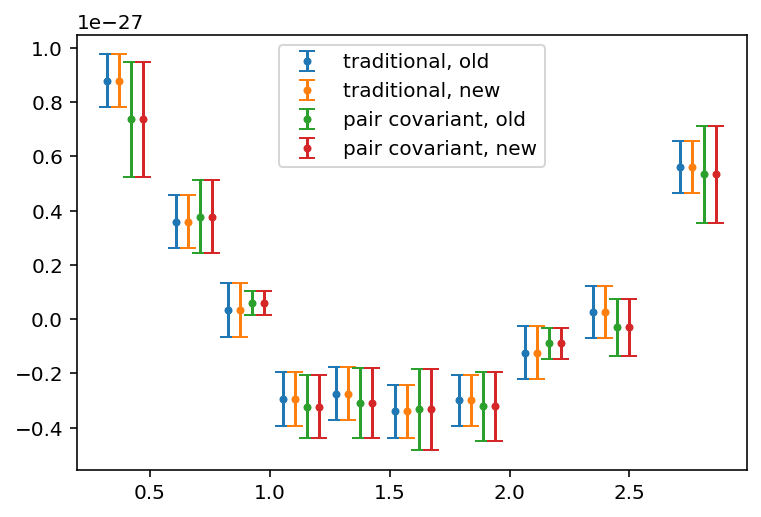

In [6]:
xia,rhoa,siga = utils.binned_pair_correlations(t_xi,t_rho,t_sig,10)
plt.errorbar(xia,rhoa,siga,fmt='.',capsize=4,label='traditional, old')

xia,rhoa,siga = utils.binned_pair_correlations(xi,rho,sig,10)
plt.errorbar(xia+0.05,rhoa,siga,fmt='.',capsize=4,label='traditional, new')

xia,rhoa,siga = utils.binned_pair_covariant_correlations(t_xi,t_rho,t_Sigma,'hd',10)
plt.errorbar(xia+0.1,rhoa,siga,fmt='.',capsize=4,label='pair covariant, old')

xia,rhoa,siga = utils.binned_pair_covariant_correlations(xi,rho,C,'hd',10)
plt.errorbar(xia+0.15,rhoa,siga,fmt='.',capsize=4,label='pair covariant, new')

plt.legend()
plt.show()

In [7]:
A2,A2s,idx = t1.compute_os(N=10,pair_covariance=True)

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


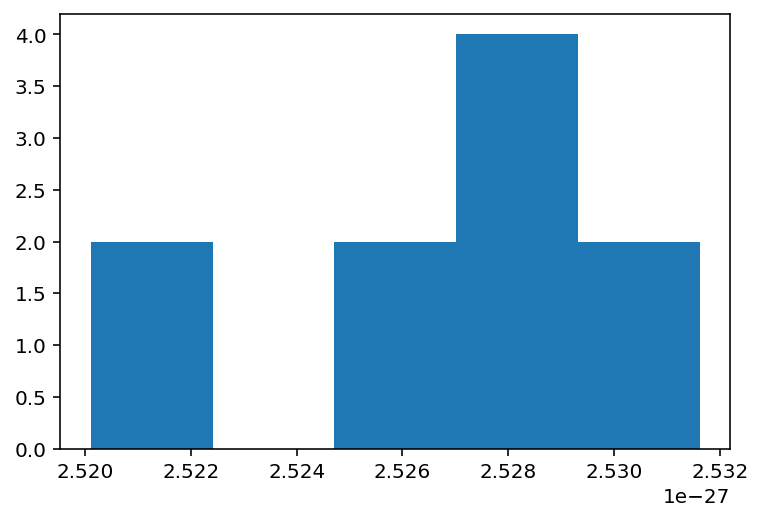

In [8]:
plt.hist(A2,bins='auto')
plt.show()

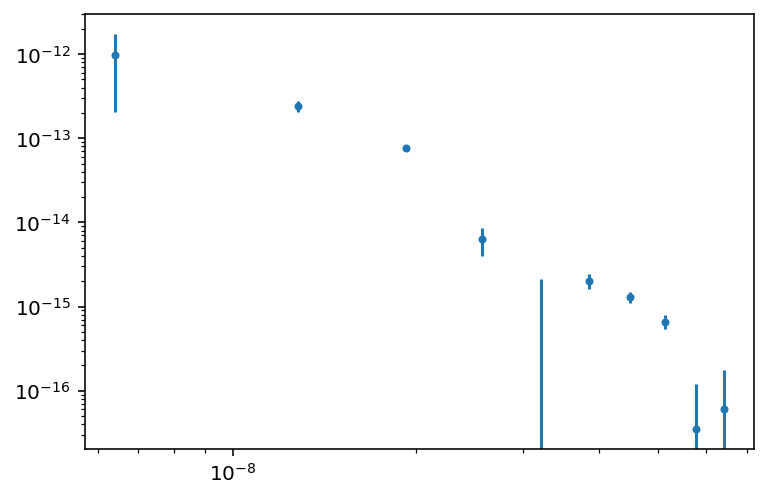

In [9]:
old_xi,old_rhok,old_sigk,old_Sk,old_Sks,fgw = compute_normPFOS(old_os,inj_params)
plt.errorbar(fgw,old_Sk,old_Sks,fmt='.')
plt.loglog()
plt.show()

100%|██████████| 10/10 [00:00<00:00, 491.57it/s]


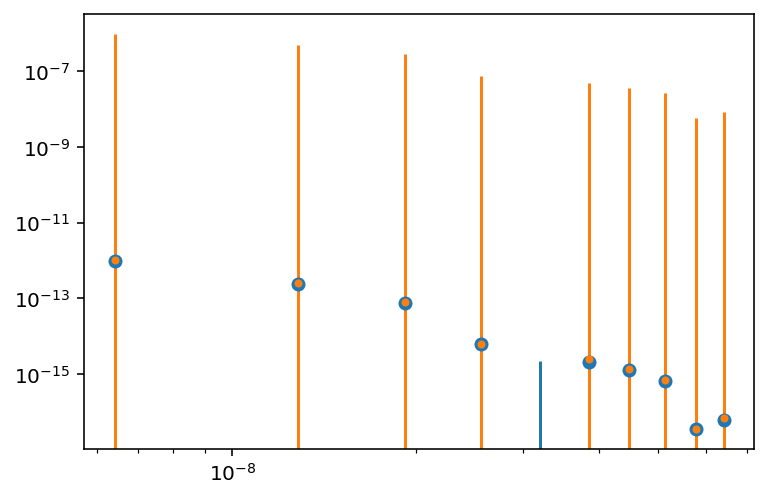

In [12]:
xi,rhok,sigk,Ck,Sk,Sks = t1.compute_pfos(inj_params,pair_covariance=False,narrowband=True,save_pair_vals=True)
plt.errorbar(fgw,old_Sk,old_Sks,fmt='o')
plt.errorbar(t1.freqs,Sk,Sks,fmt='.')
plt.loglog()
plt.show()

In [13]:
print(Sk,'\n',Sks)

[ 1.00127666e-12  2.47632776e-13  8.20246235e-14  6.03495446e-15
 -8.47745178e-14  2.45808524e-15  1.37401539e-15  6.94854758e-16
  3.57895431e-17  7.04949023e-17] 
 [1.00063813e-06 4.97627146e-07 2.86399413e-07 7.76849693e-08
            nan 4.95790807e-08 3.70677136e-08 2.63600978e-08
 5.98243622e-09 8.39612424e-09]
